In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!mkdir dataset
#!unrar e '/content/drive/MyDrive/Dataset/crackles_dataset/audio_dataset.rar' -d '/content/dataset'

In [ ]:
!mkdir dataset
!unzip '/content/drive/MyDrive/Dataset/weezels_dataset/processed_audio_weezels.zip' -d '/content/dataset'

Archive:  /content/drive/MyDrive/Dataset/weezels_dataset/processed_audio_weezels.zip
   creating: /content/dataset/content/processed_audio_weezels/
  inflating: /content/dataset/content/processed_audio_weezels/109_1b1_Pr_sc_Litt3200_12.wav  
  inflating: /content/dataset/content/processed_audio_weezels/135_2b3_Al_mc_LittC2SE_0.wav  
  inflating: /content/dataset/content/processed_audio_weezels/170_2b2_Lr_mc_AKGC417L_0.wav  
  inflating: /content/dataset/content/processed_audio_weezels/144_1b1_Tc_sc_Meditron_2.wav  
  inflating: /content/dataset/content/processed_audio_weezels/193_1b2_Pr_mc_AKGC417L_6.wav  
  inflating: /content/dataset/content/processed_audio_weezels/172_1b3_Ar_mc_AKGC417L_6.wav  
  inflating: /content/dataset/content/processed_audio_weezels/192_2b3_Al_mc_LittC2SE_4.wav  
  inflating: /content/dataset/content/processed_audio_weezels/133_2p2_Ar_mc_AKGC417L_6.wav  
  inflating: /content/dataset/content/processed_audio_weezels/199_2b1_Ll_mc_LittC2SE_2.wav  
  inflating: /

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

import pywt
import librosa as lb
import librosa.display
import soundfile as sf
import IPython.display as ipd

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             classification_report, confusion_matrix, roc_auc_score)
from sklearn.model_selection import (StratifiedKFold, train_test_split, 
                                     GridSearchCV, cross_val_score)

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

### Dataset

In [ ]:
### Audio data format txt --> List
folder = '/content/dataset'
filename_list=[]
for file in os.listdir(folder):
    if file.endswith('.txt'):
        filename_list.append(file.split('.')[0])
filename_list = sorted(filename_list)
filename_list[:5]

['101_1b1_Al_sc_Meditron',
 '101_1b1_Pr_sc_Meditron',
 '102_1b1_Ar_sc_Meditron',
 '103_2b2_Ar_mc_LittC2SE',
 '104_1b1_Al_sc_Litt3200']

In [ ]:
# Mengabungkan data txt dengan filename_list
def create_data_txt(folder, filename_list):
    audio_df = []
    #length = len(os.listdir(path))
    #index = range(length)
    
    for file in filename_list:
        loc = path+file+'.txt'
        data = pd.read_csv(loc, sep='\t', names=['start','end','crackles','weezels'])
        name_data = file.split('_')
        data['Id'] = name_data[0]
        data['filename'] = file

        audio_df.append(data)

    audio_df = pd.concat(audio_df)
    #audio_df.reset_index()
    #audio_df = audio_df.rename_axis('ID')
    return audio_df

path = '/content/dataset/'
audio_df = create_data_txt(path ,filename_list)
#audio_df.index = np.arange(1,len(audio_df)+1)
audio_df.reset_index(drop=True, inplace=True)

# Change Id dtypes into int
audio_df.Id = audio_df.Id.astype('int64')
audio_df.tail()

,start,end,crackles,weezels,Id,filename
6893,11.721,13.693,1,0,226,226_1b1_Pl_sc_LittC2SE
6894,13.693,15.536,0,0,226,226_1b1_Pl_sc_LittC2SE
6895,15.536,17.493,0,0,226,226_1b1_Pl_sc_LittC2SE
6896,17.493,19.436,1,0,226,226_1b1_Pl_sc_LittC2SE
6897,19.436,19.979,0,0,226,226_1b1_Pl_sc_LittC2SE


### Preprocessing

In [ ]:
# Seperate data normal and crackles
weezels = []
normal = []
for idx, col in audio_df.iterrows():
    if (col['crackles']==0) and (col['weezels']==0):
        normal.append(col)
    elif (col['crackles']==0) and (col['weezels']==1):
        weezels.append(col)
    else:
        pass

In [ ]:
# Normal dataframe
normal_df = pd.DataFrame(normal)
normal_df.reset_index(drop=True, inplace=True)
normal_df.tail()

,start,end,crackles,weezels,Id,filename
3637,1.207,3.550,0,0,226,226_1b1_Pl_sc_LittC2SE
3638,7.879,9.836,0,0,226,226_1b1_Pl_sc_LittC2SE
3639,13.693,15.536,0,0,226,226_1b1_Pl_sc_LittC2SE
3640,15.536,17.493,0,0,226,226_1b1_Pl_sc_LittC2SE
3641,19.436,19.979,0,0,226,226_1b1_Pl_sc_LittC2SE


In [ ]:
# Weezels dataframe
weezels_df = pd.DataFrame(weezels)
weezels_df.reset_index(drop=True, inplace=True)
weezels_df.tail()

,start,end,crackles,weezels,Id,filename
881,25.939,29.466,0,1,223,223_1b1_Ar_sc_Meditron
882,29.466,33.900,0,1,223,223_1b1_Ar_sc_Meditron
883,23.184,26.071,0,1,223,223_1b1_Pr_sc_Meditron
884,26.071,29.239,0,1,223,223_1b1_Pr_sc_Meditron
885,29.239,32.900,0,1,223,223_1b1_Pr_sc_Meditron


In [ ]:
# Concatenate weezels_df with normal_df
data_df = weezels_df.append(normal_df)

# Drop weezels column
data_df.drop('crackles', axis=1, inplace=True)
data_df.reset_index(drop=True, inplace=True)
data_df.tail()

,start,end,weezels,Id,filename
4523,1.207,3.550,0,226,226_1b1_Pl_sc_LittC2SE
4524,7.879,9.836,0,226,226_1b1_Pl_sc_LittC2SE
4525,13.693,15.536,0,226,226_1b1_Pl_sc_LittC2SE
4526,15.536,17.493,0,226,226_1b1_Pl_sc_LittC2SE
4527,19.436,19.979,0,226,226_1b1_Pl_sc_LittC2SE


In [ ]:
# Add crackles sound duration on dataframe
data_df['duration'] = (data_df.end-data_df.start)
data_df.head()

,start,end,weezels,Id,filename,duration
0,0.364,3.25000,1,103,103_2b2_Ar_mc_LittC2SE,2.88600
1,6.636,11.17900,1,103,103_2b2_Ar_mc_LittC2SE,4.54300
2,11.179,14.25000,1,103,103_2b2_Ar_mc_LittC2SE,3.07100
3,14.250,16.99300,1,103,103_2b2_Ar_mc_LittC2SE,2.74300
4,0.000,0.54469,1,104,104_1b1_Ar_sc_Litt3200,0.54469


Mean : 2.626
Median : 2.471


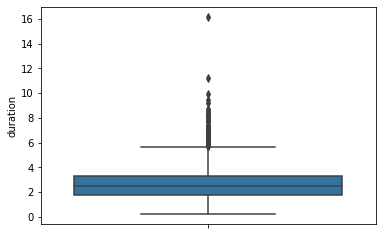

In [ ]:
# Using the average value based on the duration of the sound 
print('Mean : {:.3f}'.format(data_df.duration.mean()))
print('Median : {:.3f}'.format(data_df.duration.median()))
sns.boxplot(y=data_df.duration)
plt.show()

In [ ]:
!mkdir processed_audio_weezels
#!mkdir processed_audio_Crackles
#!mkdir processed_audio_notCrackles

In [ ]:
def getPureSample(raw_data,start,end,sr=22050):
    '''
    Takes a numpy array and spilts its using start and end args
    
    raw_data=numpy array of audio sample
    start=time
    end=time
    sr=sampling_rate
    mode=mono/stereo
    '''
    
    max_ind = len(raw_data) 
    start_ind = min(int(start * sr), max_ind)
    end_ind = min(int(end * sr), max_ind)
    return raw_data[start_ind: end_ind]

In [ ]:
def preprocessing_audio(data, path):
    i, c = 0,0
    temp_list = []
    for index,row in data.iterrows():
        maxLen=2.7
        Label = row['weezels']
        id = row['Id']
        start=row['start']
        end=row['end']
        filename=row['filename']
        
        #If len > maxLen , change it to maxLen
        if end-start>maxLen:
            end=start+maxLen
        audio_file_loc=path + filename + '.wav'

        if index > 0:
            # check if more cycles exits for same patient if so then add i to change filename
            if data.iloc[index-1]['filename'] == filename:
                i+=1
            else:
                i=0
        filename = filename + '_' + str(i) + '.wav'
        temp_list.append([id,filename,Label])    # Add to List
        save_path = '/content/processed_audio_weezels/' + filename    # Saving audio
        c+=1
        
        audioArr, sampleRate = lb.load(audio_file_loc)
        pureSample = getPureSample(audioArr, start, end, sampleRate)
        
        #pad audio if pureSample len < max_len
        reqLen = 6*sampleRate
        padded_data = lb.util.pad_center(pureSample, reqLen)    # zero-pad
        
        sf.write(file=save_path, data=padded_data, samplerate=sampleRate)
    
    lol = pd.DataFrame(temp_list)
    lol.columns = ['Id', 'File_Audio', 'Label']
    return lol
    print('Total Files Processed: ',c)

In [ ]:
# data for crackles label
start = time.perf_counter()
path = '/content/dataset/'
dataPrep_df = preprocessing_audio(data_df, path)

elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

Elapsed 3890.032 seconds.


In [ ]:
!zip -r /content/processed_audio_weezels.zip /content/processed_audio_weezels

  adding: content/processed_audio_weezels/ (stored 0%)
  adding: content/processed_audio_weezels/193_1b2_Ll_mc_AKGC417L_4.wav (deflated 76%)
  adding: content/processed_audio_weezels/170_2b2_Ar_mc_AKGC417L_3.wav (deflated 84%)
  adding: content/processed_audio_weezels/170_1b3_Lr_mc_AKGC417L_4.wav (deflated 63%)
  adding: content/processed_audio_weezels/145_2b2_Al_mc_AKGC417L_3.wav (deflated 61%)
  adding: content/processed_audio_weezels/188_1b1_Ar_sc_Meditron_11.wav (deflated 80%)
  adding: content/processed_audio_weezels/144_1b1_Tc_sc_Meditron_5.wav (deflated 68%)
  adding: content/processed_audio_weezels/146_8p3_Lr_mc_AKGC417L_3.wav (deflated 66%)
  adding: content/processed_audio_weezels/220_1b1_Tc_mc_LittC2SE_0.wav (deflated 90%)
  adding: content/processed_audio_weezels/207_2b3_Al_mc_AKGC417L_3.wav (deflated 75%)
  adding: content/processed_audio_weezels/141_1b2_Ar_mc_LittC2SE_0.wav (deflated 82%)
  adding: content/processed_audio_weezels/145_3b2_Ar_mc_AKGC417L_5.wav (deflated 81%

In [ ]:
dataPrep_df.drop_duplicates(inplace=True)
dataPrep_df.tail()

,Id,File_Audio,Label
4523,226,226_1b1_Pl_sc_LittC2SE_1.wav,0
4524,226,226_1b1_Pl_sc_LittC2SE_2.wav,0
4525,226,226_1b1_Pl_sc_LittC2SE_3.wav,0
4526,226,226_1b1_Pl_sc_LittC2SE_4.wav,0
4527,226,226_1b1_Pl_sc_LittC2SE_5.wav,0


In [ ]:
dataPrep_df.to_csv('dataPrep_weezels_df.csv', index=False)

### Feature Extraction

In [ ]:
dataPrep_df = pd.read_csv('/content/drive/MyDrive/Dataset/weezels_dataset/dataPrep_weezels_df.csv')
dataPrep_df.tail()

,Id,File_Audio,Label
4523,226,226_1b1_Pl_sc_LittC2SE_1.wav,0
4524,226,226_1b1_Pl_sc_LittC2SE_2.wav,0
4525,226,226_1b1_Pl_sc_LittC2SE_3.wav,0
4526,226,226_1b1_Pl_sc_LittC2SE_4.wav,0
4527,226,226_1b1_Pl_sc_LittC2SE_5.wav,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


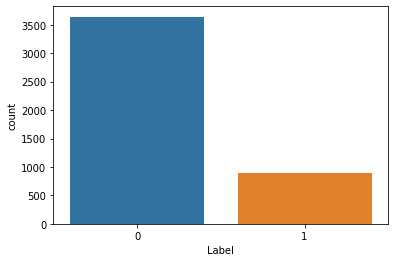

In [ ]:
sns.countplot(dataPrep_df.Label)
#plt.xticks(rotation=90)

In [ ]:
dataPrep_df.Label.value_counts()

0    3642
1     886
Name: Label, dtype: int64

In [ ]:
# Seperate
normal = dataPrep_df[dataPrep_df.Label==0][:886]
weezels = dataPrep_df[dataPrep_df.Label==1]

# Combine
data_train = normal.append([weezels])
data_train.reset_index(drop=True, inplace=True)
data_train

,Id,File_Audio,Label
0,101,101_1b1_Al_sc_Meditron_0.wav,0
1,101,101_1b1_Al_sc_Meditron_1.wav,0
2,101,101_1b1_Al_sc_Meditron_2.wav,0
3,101,101_1b1_Al_sc_Meditron_3.wav,0
4,101,101_1b1_Al_sc_Meditron_4.wav,0
...,...,...,...
1767,223,223_1b1_Ar_sc_Meditron_8.wav,1
1768,223,223_1b1_Ar_sc_Meditron_9.wav,1
1769,223,223_1b1_Pr_sc_Meditron_0.wav,1
1770,223,223_1b1_Pr_sc_Meditron_1.wav,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


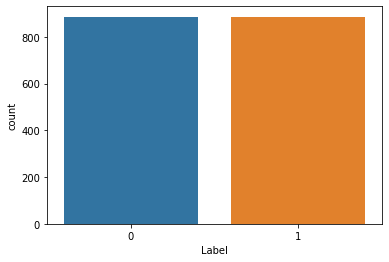

In [ ]:
sns.countplot(data_train.Label)
#plt.xticks(rotation=90)

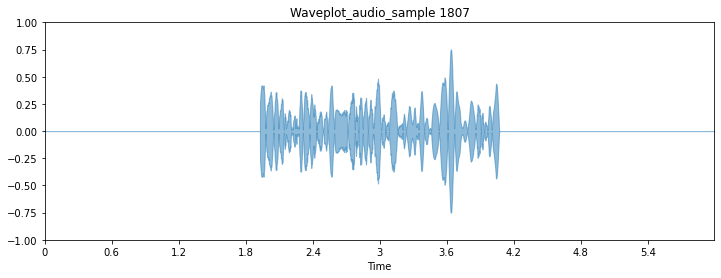

In [ ]:
# Plotting
random_num = np.random.randint(0,len(dataPrep_df))
sample_audio = dataPrep_df.File_Audio.loc[random_num]
root = '/content/dataset/content/processed_audio_weezels/'
path = root+sample_audio

plt.figure(figsize=(12,4))
audio_arr, sr = lb.load(path)
lb.display.waveplot(audio_arr, alpha=0.5)
plt.ylim(-1,1)
plt.title('Waveplot_audio_sample '+str(random_num))
plt.show()

In [ ]:
def calculate_statistics(list_values):
    min = np.min(list_values)
    max = np.max(list_values)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    return [min, n25, n75, max, median, mean, std]

def get_features(list_values):
    statistics = calculate_statistics(list_values)
    return statistics

In [ ]:
# Using Daubechies_2
def features_extraction(path):
    soundArr,sample_rate = lb.load(path)
    waveletname = 'db2'
    list_coef = pywt.wavedec(soundArr, waveletname, level=5)
    return list_coef

In [ ]:
start = time.perf_counter()
root='/content/dataset/content/processed_audio_weezels/'
feature_list = []
for idx,row in data_train.iterrows():
    path = root + row['File_Audio']
    list_coef = features_extraction(path)    # Wavelet
    temp = []
    for coef in list_coef:
        temp+=get_features(coef)    # Calculate statistic value
    feature_list.append(temp)

feature_list = np.array(feature_list)
feature_label = np.array(data_train.Label, np.int)

print(feature_list.shape)
print(feature_label.shape)
elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

(1772, 42)
(1772,)
Elapsed 21.632 seconds.


In [ ]:
print(feature_list[1])

[-1.13565791e+00  0.00000000e+00  0.00000000e+00  2.18627167e+00
  0.00000000e+00 -1.54975208e-03  2.32089162e-01 -8.11752230e-02
  0.00000000e+00  0.00000000e+00  1.28828391e-01  0.00000000e+00
  2.82406945e-05  7.21561443e-03 -8.04016739e-02  0.00000000e+00
  0.00000000e+00  3.38323265e-02  0.00000000e+00 -1.23088657e-05
  1.68487756e-03 -5.73042333e-02  0.00000000e+00  0.00000000e+00
  2.27609873e-02  0.00000000e+00 -1.53814756e-06  6.21145649e-04
 -4.15697992e-02  0.00000000e+00  0.00000000e+00  1.04599185e-02
  0.00000000e+00 -9.66249786e-07  2.53982493e-04 -3.07453386e-02
  0.00000000e+00  0.00000000e+00  7.69114681e-03  0.00000000e+00
 -3.67654394e-07  1.26918938e-04]


### Model

In [ ]:
# In the following plot we can see that classes are imbalanced so we must split 
# them into train and validation set via stratify

x_train, x_test, y_train, y_test = train_test_split(feature_list, feature_label, 
                                                    test_size=.2, 
                                                    random_state=0)

print(x_train.shape)
print(x_test.shape)

(1417, 42)
(355, 42)


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
start = time.perf_counter()
# Model
gbc = GradientBoostingClassifier(n_estimators=900, learning_rate=0.1)

# Validation
#cv = StratifiedKFold(n_splits=10)
#validation = cross_val_score(gbc, x_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)

# Training
gbc.fit(x_train, y_train)
y_pred_test = gbc.predict(x_test)

elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

Elapsed 10.236 seconds.


In [ ]:
#print('Accuracy_Val : {:.4f}\n'.format(validation.mean()))

print('Accuracy_test : {:.4f}'.format(accuracy_score(y_test, y_pred_test)), 
      'Precision_test : {:.4f}'.format(precision_score(y_test, y_pred_test, average='macro')), 
      'Recall_test : {:.4f}'.format(recall_score(y_test, y_pred_test, average='macro')), 
      'F1-Score : {:.4f}'.format(f1_score(y_test, y_pred_test, average='macro')))

# Classification report
target_names = ['notCrackles','crackles']
print('\nclassification report testing : \n', classification_report(y_test, y_pred_test, 
                                                                  target_names=target_names))

print('Elapsed %.3f seconds.' % elapsed)

Accuracy_test : 0.6085 Precision_test : 0.6086 Recall_test : 0.6085 F1-Score : 0.6084

classification report testing : 
               precision    recall  f1-score   support

 notCrackles       0.61      0.60      0.60       178
    crackles       0.60      0.62      0.61       177

    accuracy                           0.61       355
   macro avg       0.61      0.61      0.61       355
weighted avg       0.61      0.61      0.61       355

Elapsed 10.236 seconds.


In [ ]:
# Hyperparameter using GridSearchCv
start = time.perf_counter()
params_grid = dict(n_estimators=list(range(100,1000,100)), 
                   learning_rate=[0.001,0.1]) 

gbc = GradientBoostingClassifier()
cv = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
grid_search = GridSearchCV(gbc, param_grid=params_grid,
                           cv=cv, n_jobs=-1, verbose=10)

grid_search.fit(x_train, y_train)
#result = pd.DataFrame(grid_search_SVC.cv_results_)
elapsed = time.perf_counter() - start

print('Best score: {:.2f}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
print('Elapsed %.3f seconds.' % elapsed)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  7

Best score: 0.68
Best parameters: {'learning_rate': 0.1, 'n_estimators': 900}
Elapsed 659.287 seconds.
